Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Daniil Krechko | 12149099 | 27.04.2023, 08:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 3 &ndash; Drug Discovery (Assignment)</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Schimunek, J. Brandstetter, E. Kobler<br>
<b>Date:</b> 18-04-2023

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u3_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u3_utils.py</code> need to be installed.

In [199]:
# Import pre-defined utilities specific to this notebook.
import u3_utils as u3

# Import additional utilities needed in this notebook.
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy
from rdkit import Chem

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u3.setup_jupyter()

# Check minimum versions.
u3.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.23.5 (✓)
Installed pandas version: 1.5.2 (✓)
Installed scikit-learn version: 1.2.2 (✓)
Installed matplotlib version: 3.6.2 (✓)
Installed seaborn version: 0.12.1 (✓)
Installed PIL version: 9.2.0 (✓)
Installed rdkit version: 2022.09.5 (✓)


<h2>Extracting Information of MOL/SDF Representations</h2>
<p>The first step of working with molecule data is actually getting them into memory. <tt>RDKit</tt> provides this functionality with <code>SDMolSupplier</code> – be aware that the specified file is <i>not</i> loaded at once, but piece by piece, depending on what information is retrieved. This behavior is solely for performance reasons, hence you do not need to worry about this besides <i>not</i> deleting/moving the specified data file during the whole process.</p>

<div class="alert alert-warning">
    <b>Exercise 1.1. [15 Points]</b>
    <ul>
        <li>Load the <i>molecule</i> data set <tt>molecules.sdf</tt> using the appropriate function as supplied by <tt>RDKit</tt>.</li>
        <li>To avoid any problems with the <i>lazy</i> loading mechanics of <tt>RDKit</tt>, print the total amount of loaded molecules.</li>
        <li>Visualize the $8$ molecules with the <i>lowest LogP</i> values in a <i>$2\times 4$ grid</i> including their <i>Formulas</i> as well as their <i>LogP</i> values.</li>
        <li>What does the acronym <i>LogP</i> stand for? Which property do the extracted molecules share? Cite your sources (find an appropriate source, even if you know it by heart).</li>
    </ul>
</div>

218 molecules loaded from file.


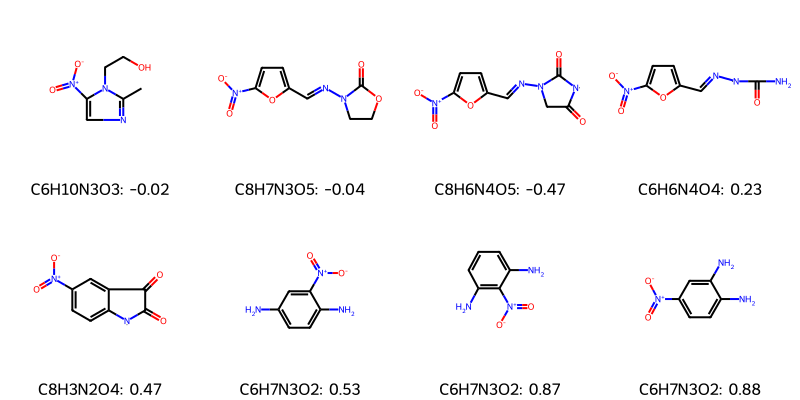

In [200]:
data_molecules = Chem.SDMolSupplier('molecules.sdf')
num_molecules = len(data_molecules)
print(f'{num_molecules} molecules loaded from file.')
sorted_moles = {}
for i, mol in enumerate(data_molecules):
    sorted_moles[i] = mol.GetProp("LogP")
sorted_moles = dict(sorted(sorted_moles.items(), key=lambda x: x[1]))
specific_molecules = [data_molecules[i[0]] for i in list(sorted_lps.items())]
molecule_labels = [f'{mol.GetProp("Formula")}: {mol.GetProp("LogP")}' for mol in specific_molecules]
Chem.Draw.MolsToGridImage(
    specific_molecules[:8],
    legends=molecule_labels,
    maxMols=len(specific_molecules),
    molsPerRow=4
)


<div class="alert alert-warning">
    <b>Exercise 1.2. [10 Points]</b>
    <ul>
        <li>For each of the previously found molecules, <i>annote</i> each atom by its degree and compute each molecule's <i>atom count</i>.</li>
        <li>Visualize the result in a <i> $2\times 4$ grid</i> including their <i>Formulas</i> as well as their <i>atom counts</i> (sorted in descending order according to <i>atom count</i>).</li>
        <li>Do you observe <i>visually similar</i> molecules? In either case, comment on their respective differences.</li>
    </ul>
</div>

In [201]:
def annotate_molecule_atoms(molecule: Chem.rdchem.Mol) -> Chem.rdchem.Mol:
    """
    Annotate molecule atoms with its degree.
    
    :param molecule: molecule to annotate
    :return: annotated molecule
    """
    molecule_annotated = deepcopy(molecule)
    for atom in molecule_annotated.GetAtoms():
        atom.SetProp('atomNote', str(atom.GetDegree()))
    return molecule_annotated


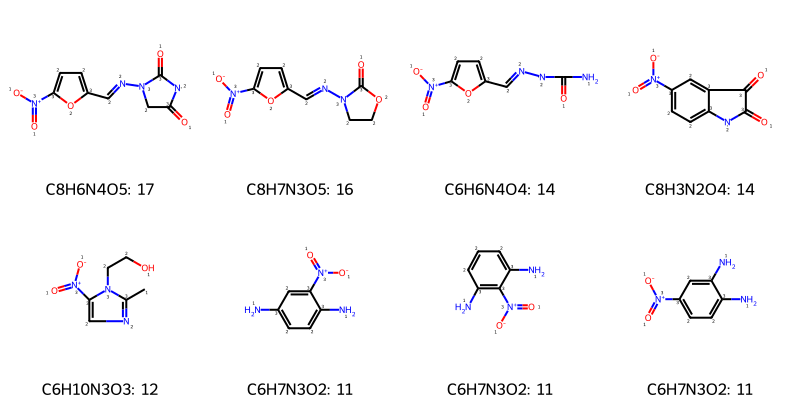

In [202]:
# your code goes here
annotated_molecules = []

for i in range(8):
    annotated_molecule = annotate_molecule_atoms(specific_molecules[i])
    annotated_molecules.append(annotated_molecule)

sorted_molecules = []

for molecule in annotated_molecules:
    num_atoms = molecule.GetNumAtoms()
    molecule.SetProp('atomCount', str(num_atoms))
    sorted_molecules.append(molecule)

sorted_molecules = sorted(sorted_molecules, key=lambda x: x.GetProp('atomCount'), reverse=True)

sorted_molecules_labels = [f'{molecule.GetProp("Formula")}: {molecule.GetProp("atomCount")}' for molecule in sorted_molecules]

# sorted_molecules_labels = []
# for molecule in sorted_molecules:
#     formula = molecule.GetProp('Formula')
#     atom_count = molecule.GetProp('atomCount')
#     label = f"{formula}: {atom_count}"
#     sorted_molecules_labels.append(label)

# Draw the sorted molecules using the MolsToGridImage function.
Chem.Draw.MolsToGridImage(
    sorted_molecules,
    legends=sorted_molecules_labels,
    maxMols=len(specific_molecules),
    molsPerRow=4
)

<h2>Atomic Properties and Bonds</h2>
<p>Extracting <i>atomic</i> as well as <i>bond</i> properties often allows for a more thorough undertstanding of the molecules at hand. Unsurprisingly, <tt>RDKit</tt> provides the necessary functionality for this purpose – almost. The missing functionality may be taken from the exercise notebook, but needs to be adapted accordingly.</p>

<div class="alert alert-warning">
    <b>Exercise 2.1. [10 Points]</b>
    <ul>
        <li>Compute the <i>amount of atoms</i> participating in a <i>ring structure</i> for each of the molecules of the previous exercise.</li>
        <li>Adapt and apply <code>annotate_molecule_atoms</code> in a way to annotate an atom with an <tt>R</tt> if it is <i>participating</i> in a ring structure.</li>
        <li>Visualize the result in a <i> $2\times 4$ grid</i> including their <i>Formulas</i> as well as their <i>amount of ring atoms</i> (sorted in descending order according to the latter).</li>
    </ul>
</div>

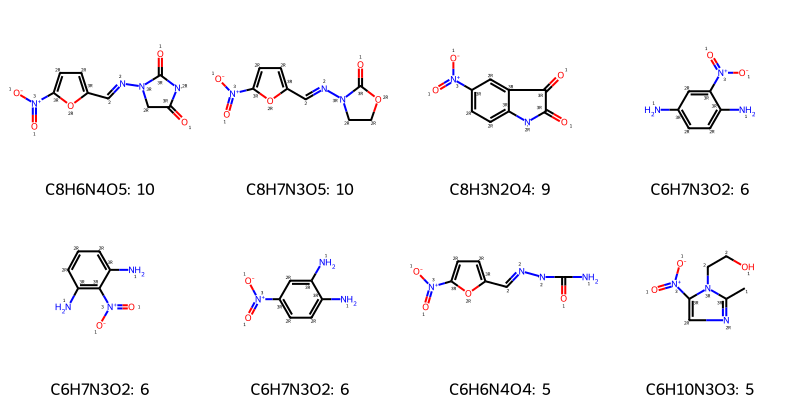

In [203]:
annote_molecules_ring = []
for i, molecule in enumerate(sorted_molecules):
    if i < 8:
        annotated_molecule = annotate_molecule_atoms(molecule)
        ring_count = 0
        for atom in annotated_molecule.GetAtoms():
            atom.SetProp('atomNote', str(f"{atom.GetDegree()}R" if atom.IsInRing() else atom.GetDegree()))
            if atom.GetProp("atomNote")[-1] == 'R':
                ring_count += 1
        annotated_molecule.SetProp('ringCount', str(ring_count))
        annote_molecules_ring.append(annotated_molecule)
    sorted_molecules_ring = sorted(annote_molecules_ring, key=lambda x: int(x.GetProp('ringCount')), reverse=True)
    sorted_molecules_ring_labels = [f'{molecule.GetProp("Formula")}: {molecule.GetProp("ringCount")}' for molecule in sorted_molecules_ring]
    

Chem.Draw.MolsToGridImage(
    sorted_molecules_ring,
    legends=sorted_molecules_ring_labels,
    maxMols=len(specific_molecules),
    molsPerRow=4)






<div class="alert alert-warning">
    <b>Exercise 2.2. [10 Points]</b>
    <ul>
        <li>Compute the <i>amount of double-type bonds</i> for each of the molecules of the previous exercise.</li>
        <li>Adapt and apply <code>annotate_molecule_bonds</code> in a way to mark bonds with the <i>first letter</i> of their respective <i>type</i>.</li>
        <li>Visualize the result in a <i> $2\times 4$ grid</i> including their <i>Formulas</i> as well as their <i>amount of double bonds</i> (sorted in descending order according to the latter).</li>
    </ul>
</div>

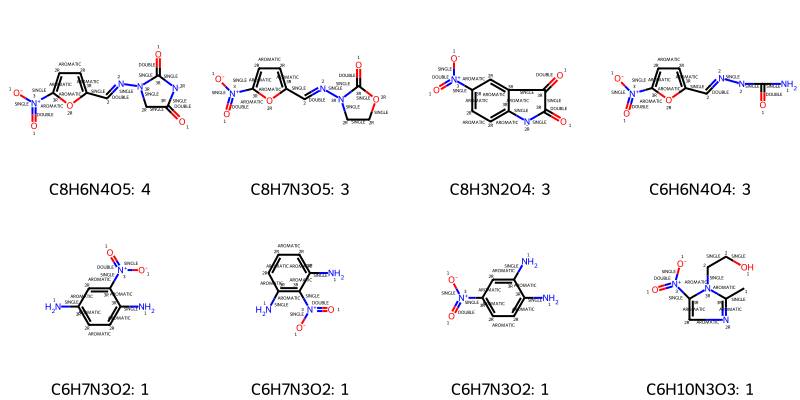

In [204]:
# your code goes here
def annotate_molecule_bonds(molecule: Chem.rdchem.Mol) -> Chem.rdchem.Mol:
    """
    Annotate molecule atoms with its degree.
    
    :param molecule: molecule to annotate
    :return: annotated molecule
    """
    molecule_annotated = deepcopy(molecule)
    for atom in molecule_annotated.GetAtoms():
        atom.SetProp('atomNote', str(f"{atom.GetDegree()}R" if atom.IsInRing() else atom.GetDegree()))
    for bond in molecule_annotated.GetBonds():
        bond.SetProp('bondNote', str(bond.GetBondType()))
    return molecule_annotated


annotated_molecules = []
for molecule in sorted_molecules_ring:
    annotated_molecule = annotate_molecule_bonds(molecule)
    annotated_molecules.append(annotated_molecule)

annotated_molecules.sort(key=lambda molecule: sum(1 for bond in molecule.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE), reverse=True)

# double_bond_count = sum(1 for bond in molecule.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE)

sorted_moles_labels_bonds = [f'{molecule.GetProp("Formula")}: {sum(1 for bond in molecule.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE)}' for molecule in annotated_molecules]
                                                                     # molecule.GetProp("dtBonds")
Chem.Draw.MolsToGridImage(
    annotated_molecules,
    legends=sorted_moles_labels_bonds,
    maxMols=len(specific_molecules),
    molsPerRow=4)


<h2>Further Applications</h2>
<p>In the following exercises, you'll have to dig into the more interesting applications of chemoinformatics, namely:
<ul>
    <li>molecular substructure matching</li>
    <li>molecular fingerprints</li>
    <li>molecular clustering</li>
</ul></p>

<div class="alert alert-warning">
    <b>Exercise 3.1. [10 Points]</b>
    <ul>
        <li>Specify a <tt>CCO</tt> template and scan the full molecules data set. Visualize the template including a respective <i>atom numbering</i>.</li>
        <li>For each of the found molecules, <i>annote</i> their atoms and compute their respective <i>substructure matches</i> (w.r.t. <tt>CCO</tt>).</li>
        <li>Visualize the result in a <i>grid</i> including their <i>substructure matches</i>. Can you recognize the substructures in the plot?</li>
    </ul>
</div>

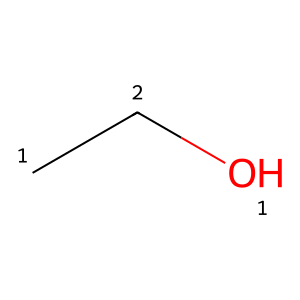

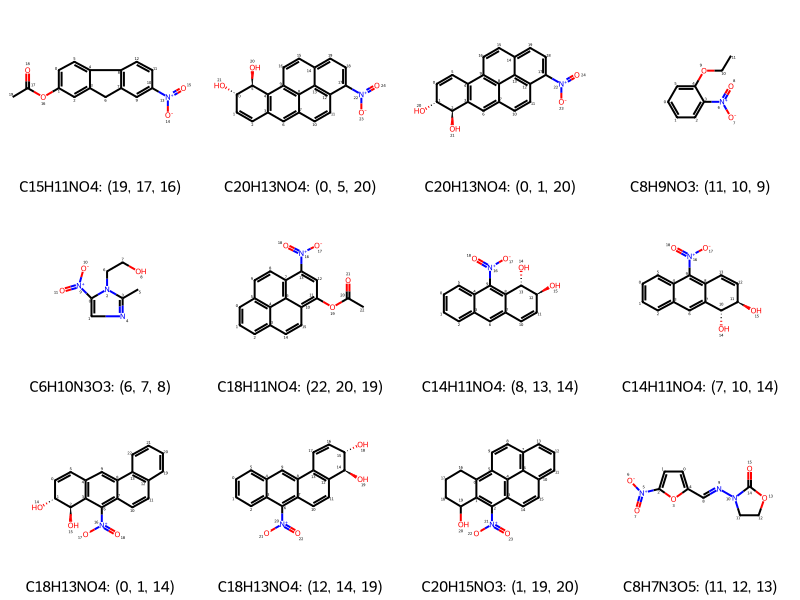

In [205]:
# your code goes here
def annotate_molecule_cco(molecule: Chem.rdchem.Mol) -> Chem.rdchem.Mol:
    """
    Annotate molecule atoms with corresponding atom numbers.
    
    :param molecule: molecule to annotate
    :return: annotated molecule
    """
    molecule_annotated = deepcopy(molecule)
    for atom in molecule_annotated.GetAtoms():
        atom.SetProp('atomNote', str(atom.GetIdx()))
    if molecule_annotated.HasSubstructMatch(cco_match):
        molecule_annotated.SetProp('subStruct', str(molecule_annotated.GetSubstructMatch(cco_match)))
    return molecule_annotated

cco_match = Chem.MolFromSmiles('CCO')

cco_match_annotated = annotate_molecule_atoms(cco_match)
cco_match_image = Chem.Draw.MolToImage(cco_match_annotated)
display(cco_match_image)

matched_molecules = []
for molecule in data_molecules:
    if molecule.HasSubstructMatch(cco_match):
        matched_molecules.append(annotate_molecule_cco(molecule))

labels = [f'{molecule.GetProp("Formula")}: {molecule.GetProp("subStruct")}' for molecule in matched_molecules]
Chem.Draw.MolsToGridImage(
    matched_molecules,
    legends=labels,
    maxMols=len(matched_molecules),
    molsPerRow=4)


<div class="alert alert-warning">
    <b>Exercise 3.2. [20 Points]</b>
    <ul>
        <li>Compute the <i>ECFPs</i> from the previously found molecules and visualize them in tabular form (use a <i>fold size</i> of $256$).</li>
        <li>How many <i>substructures</i> are present in each molecule? Compute and sort their <i>total amount</i> for each molecule.</li>
    </ul>
</div>

In [206]:
# your code goes here
data_molecules_smiles = [Chem.MolToSmiles(molecule) for molecule in matched_molecules]

# Afterwards, ECFPs are computed and visualized in tabular form.
data_molecules_ecfps = u3.compute_ecfps(data_molecules_smiles, fold=256)
total = data_molecules_ecfps.sum(axis=1)
smiles_quantities = []
for i in range(len(data_molecules_smiles)):
    smiles = data_molecules_smiles[i]
    quantity = total[i]
    smiles_quantities.append((smiles, quantity))

smiles_quantities_sorted = sorted(smiles_quantities, key=lambda x: x[1], reverse=True)
for elem in smiles_quantities_sorted:
    print(elem)
print("12 substructure matches in total")
data_molecules_ecfps
# pd.DataFrame(data_molecules_ecfps.sum(axis=1)).transpose()

('O=[N+]([O-])c1ccc2ccc3c4c(cc5ccc1c2c53)C=C[C@H](O)[C@H]4O', 56)
('O=[N+]([O-])c1ccc2ccc3c4c(cc5ccc1c2c53)[C@@H](O)[C@H](O)C=C4', 52)
('O=[N+]([O-])c1c2c(cc3c1ccc1ccccc13)C=C[C@@H](O)[C@@H]2O', 52)
('O=[N+]([O-])c1c2ccccc2cc2c3c(ccc12)[C@H](O)[C@@H](O)C=C3', 52)
('O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2O', 51)
('CC(=O)Oc1cc([N+](=O)[O-])c2ccc3cccc4ccc1c2c43', 46)
('CC(=O)Oc1ccc2c(c1)Cc1cc([N+](=O)[O-])ccc1-2', 45)
('O=[N+]([O-])c1c2c(cc3ccccc13)C=C[C@H](O)[C@H]2O', 45)
('O=[N+]([O-])c1c2c(cc3ccccc13)[C@@H](O)[C@H](O)C=C2', 43)
('O=C1OCCN1/N=C/c1ccc([N+](=O)[O-])o1', 40)
('Cc1ncc([N+](=O)[O-])n1CCO', 34)
('CCOc1ccccc1[N+](=O)[O-]', 29)
12 substructure matches in total


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
1,False,False,False,False,True,False,True,True,False,True,...,False,False,False,False,False,True,False,True,False,False
2,False,False,False,True,True,False,False,True,False,True,...,False,False,False,True,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
5,False,False,True,False,False,True,False,False,True,True,...,False,False,False,True,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
7,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
9,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


<div class="alert alert-warning">
    <b>Exercise 3.3. [25 Points]</b>
    <ul>
        <li>Downproject the previously computed <i>ECFPs</i> using <i>t-SNE</i> (use a seed of $42$, and a perplexity of $3.0$).</li>
        <li>Visualize the result in a <i>scatter plot</i>. Are there any visible clusters?</li>
            <li>Cluster the resulting downprojections using <i>affinity propagation</i>. Why would <i>k-means</i> be a little bit disadvantageous here?</li>
        <li>Plot all molecules of all <i>clusters</i> in separate <i>grids</i> including their <i>Compound Name</i> and <i>LogP</i>. Do you see similarities?</li>
    </ul>
</div>

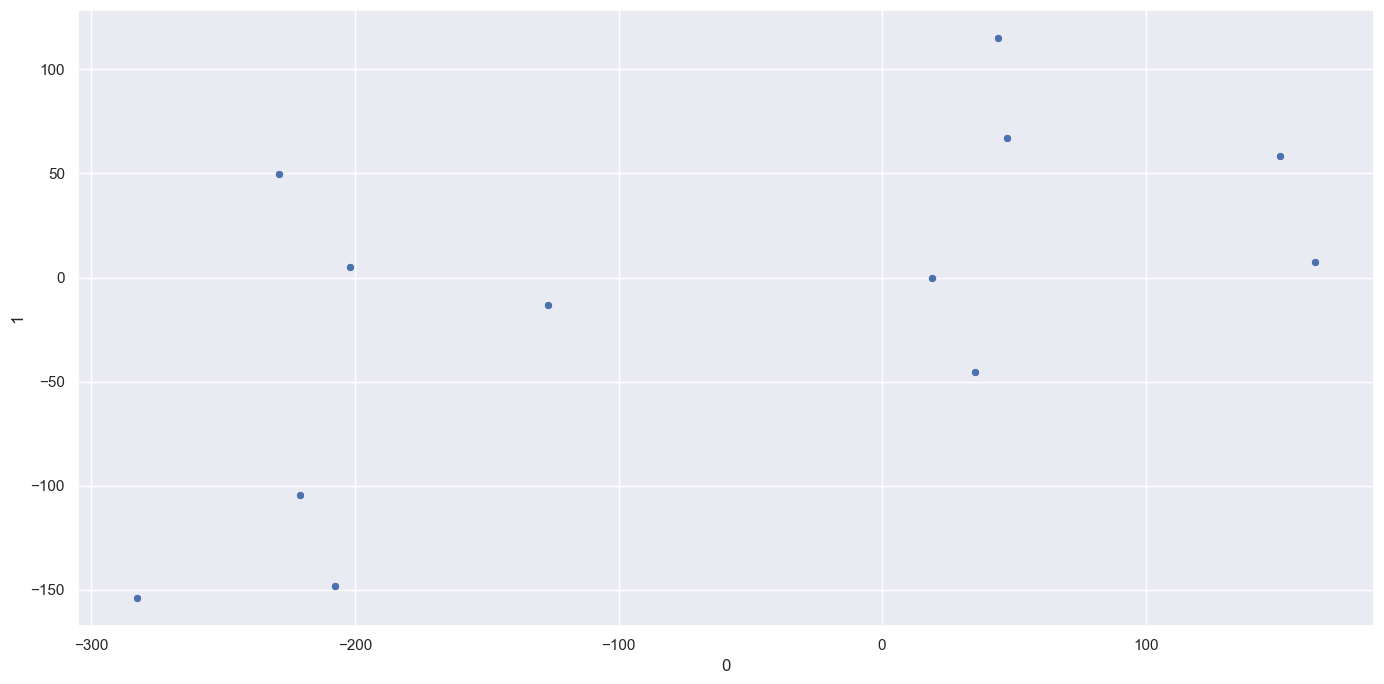

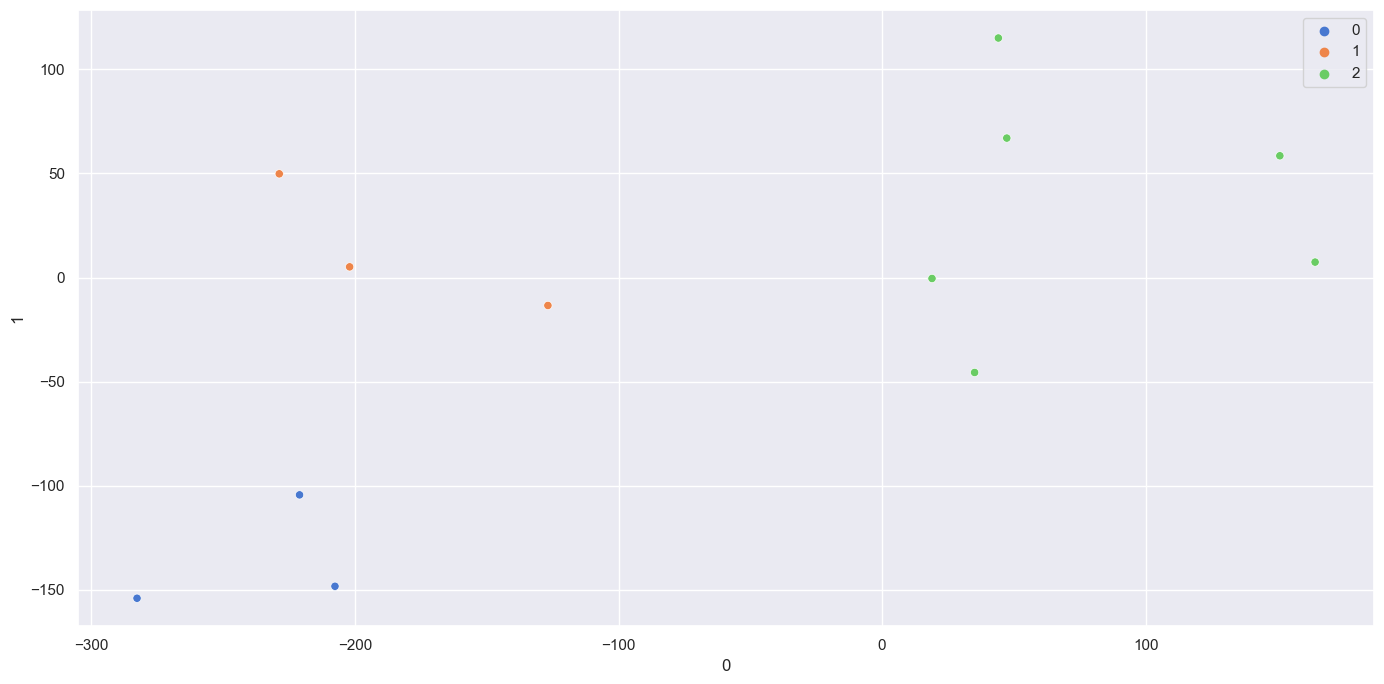

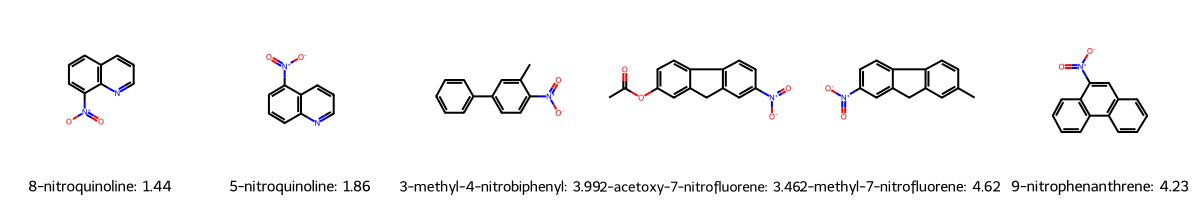

In [207]:
# your code goes here
np.random.seed(seed=42)
data_molecules_ecfps_tsne = u3.apply_tsne(n_components=2, data=data_molecules_ecfps, perplexity=3.0)
u3.plot_points_2d(data=data_molecules_ecfps_tsne, figsize=(14, 7))

#some clusters are visible but they are not clearly defined

affinity_propagation_clusters_tsne = u3.apply_affinity_propagation(data=data_molecules_ecfps_tsne)
u3.plot_points_2d(data=data_molecules_ecfps_tsne, targets=affinity_propagation_clusters_tsne, figsize=(14, 7))

#k-means clustering requires a predifined number of clusters as input and data should be well separated in order to work well, but it's not our case,
#so we are using affinity propagation.

cluster_indices = data_molecules_ecfps_tsne[affinity_propagation_clusters_tsne == 2].index
cluster_molecules = [data_molecules[i] for i in cluster_indices]
cluster_molecule_labels = [f'{mol.GetProp("Compound Name")}: {mol.GetProp("LogP")}' for mol in cluster_molecules]

Chem.Draw.MolsToGridImage(
    cluster_molecules,
    legends=cluster_molecule_labels,
    maxMols=len(cluster_molecules),
    molsPerRow=6
)

#After plotting all molecules of all clusters in separate grids we can see that 3 first molecules most likely belong to 1 class and 3 left
#molecules belong to another. The structure of molecules within 1 class is almost the same. Thus, we chose the right clustering algorithm.